<a href="https://colab.research.google.com/github/ujjwalbb30/CMSC_678_ASL_image_classification_ML/blob/main/python_notebooks/Part_1_2_CNN_ReLU_ASL_Image_Classification_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifiying American Sign Language (ASL) images using Covolutional Neural Network (CNN) models**
# **Activation Function : 'ReLU'**

In this notebook, I will be training 10 different CNN models to classify ASL images. I will mainly use 'ReLU' activation function in the hidden layers. I will be conducting following experiments in this notebook:

▶ 5 different CNN models (with 1 Convolutional layer, 1 MaxPooling layer and 1 Dropout Layer) will be trained with following kernel sizes:

>(a) (4,4)

>(b) (5,5)

>(c) (6,6)

>(d) (7,7)

>(e) (8,8)

▶ For each kernel size mentioned above, 1 more type of CNN model (having the following characteristics), will be trained:

>(a) 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers

▶ In total, 10 models will be trained and following metrics will be calculated for each model along with Confusion matrix:

> (a) Accuracy

> (b) Precision

> (c) Recall

> (d) F1-score

## **Importing required libraries and data**

In [ ]:
# installing split-folders library to split the images dataset folders into training, validation and testing folders
!pip install split-folders

###**Importing required libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import random
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing tensorflow, keras and their required modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# importing sklearn and their required modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import os
import gc

import splitfolders

###**Mounting the drive and copying the data to allocated machine**

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied
drive_path = '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset' '/content'

Streaming output truncated to the last 5000 lines.
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1898.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1898.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1904.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1904.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1890.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1890.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1880.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1880.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1908.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1908.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1888.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1888.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1876.jpg' -> '/content/dataset/asl_alphabet_tr

###**Splitting the images dataset folder into train, validation and test images**
###**creating train, validation and test dataframes of image paths and labels**

In [ ]:
# splitting the folder intro training, validation and test dataset
splitfolders.ratio("/content/dataset/asl_alphabet_train", output="/content/dataset/split_dataset", seed=42, ratio=(.7, .1, .2), group_prefix=None)

Copying files: 87020 files [00:10, 8132.07 files/s]


In [ ]:
# Exploring the new created split dataset folder
dataset_folder_path = '/content/dataset/split_dataset'
for path, directories, files in os.walk(dataset_folder_path):
    print(path,'--> number of files : ', len(files))

/content/dataset/split_dataset --> number of files :  0
/content/dataset/split_dataset/test --> number of files :  0
/content/dataset/split_dataset/test/X --> number of files :  600
/content/dataset/split_dataset/test/J --> number of files :  600
/content/dataset/split_dataset/test/G --> number of files :  600
/content/dataset/split_dataset/test/D --> number of files :  600
/content/dataset/split_dataset/test/A --> number of files :  600
/content/dataset/split_dataset/test/R --> number of files :  600
/content/dataset/split_dataset/test/N --> number of files :  602
/content/dataset/split_dataset/test/T --> number of files :  600
/content/dataset/split_dataset/test/B --> number of files :  600
/content/dataset/split_dataset/test/H --> number of files :  600
/content/dataset/split_dataset/test/W --> number of files :  600
/content/dataset/split_dataset/test/E --> number of files :  600
/content/dataset/split_dataset/test/Q --> number of files :  600
/content/dataset/split_dataset/test/C 

In [ ]:
# Preparing train, validation and test dataframes of image paths and labels

# defining the path to train, validation and test images data folders
train_dataset_folder = '/content/dataset/split_dataset/train'
validation_dataset_folder = '/content/dataset/split_dataset/val'
test_dataset_folder = '/content/dataset/split_dataset/test'

# initializing empty lists to store paths and labels of train, validation and test images
train_data = []
val_data = []
test_data = []

# saving train images paths and labels
for folder in os.listdir(train_dataset_folder):
    label_folder = os.path.join(train_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles

# saving validation images paths and labels
for folder in os.listdir(validation_dataset_folder):
    label_folder = os.path.join(validation_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    val_data += onlyfiles

# saving test images paths and labels
for folder in os.listdir(test_dataset_folder):
    label_folder = os.path.join(test_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    test_data += onlyfiles

# creating dataframes from the lists
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# viewing the details of training dataframe
print('training data:\n')
display(train_data_df)
print('\nunique labels:\n',train_data_df['label'].unique())
print('\n number of unique labels:\n',train_data_df['label'].nunique())

# viewing the details of validation dataframe
print('\nvalidation data:\n')
display(val_data_df)
print('\nunique labels:\n',val_data_df['label'].unique())
print('\n number of unique labels:\n',val_data_df['label'].nunique())

# viewing the details of testing dataframe
print('\ntesting data:\n')
display(test_data_df)
print('\nunique labels:\n',test_data_df['label'].unique())
print('\n number of unique labels:\n',test_data_df['label'].nunique())

training data:



label                                              path
0         X    /content/dataset/split_dataset/train/X/X74.jpg
1         X   /content/dataset/split_dataset/train/X/X502.jpg
2         X  /content/dataset/split_dataset/train/X/X2189.jpg
3         X  /content/dataset/split_dataset/train/X/X2330.jpg
4         X   /content/dataset/split_dataset/train/X/X250.jpg
...     ...                                               ...
60909     M  /content/dataset/split_dataset/train/M/M2725.jpg
60910     M  /content/dataset/split_dataset/train/M/M1168.jpg
60911     M  /content/dataset/split_dataset/train/M/M1072.jpg
60912     M  /content/dataset/split_dataset/train/M/M2842.jpg
60913     M  /content/dataset/split_dataset/train/M/M2745.jpg

[60914 rows x 2 columns]


unique labels:
 ['X' 'J' 'G' 'D' 'A' 'R' 'N' 'T' 'B' 'H' 'W' 'E' 'Q' 'C' 'space' 'del' 'P'
 'S' 'O' 'K' 'Z' 'U' 'L' 'V' 'nothing' 'F' 'I' 'Y' 'M']

 number of unique labels:
 29

validation data:



label                                            path
0        X  /content/dataset/split_dataset/val/X/X2630.jpg
1        X  /content/dataset/split_dataset/val/X/X1889.jpg
2        X  /content/dataset/split_dataset/val/X/X2532.jpg
3        X  /content/dataset/split_dataset/val/X/X1679.jpg
4        X   /content/dataset/split_dataset/val/X/X840.jpg
...    ...                                             ...
8697     M  /content/dataset/split_dataset/val/M/M1903.jpg
8698     M  /content/dataset/split_dataset/val/M/M1898.jpg
8699     M  /content/dataset/split_dataset/val/M/M1093.jpg
8700     M  /content/dataset/split_dataset/val/M/M2329.jpg
8701     M    /content/dataset/split_dataset/val/M/M52.jpg

[8702 rows x 2 columns]


unique labels:
 ['X' 'J' 'G' 'D' 'A' 'R' 'N' 'T' 'B' 'H' 'W' 'E' 'Q' 'C' 'space' 'del' 'P'
 'S' 'O' 'K' 'Z' 'U' 'L' 'V' 'nothing' 'F' 'I' 'Y' 'M']

 number of unique labels:
 29

testing data:



label                                             path
0         X   /content/dataset/split_dataset/test/X/X260.jpg
1         X   /content/dataset/split_dataset/test/X/X651.jpg
2         X  /content/dataset/split_dataset/test/X/X1917.jpg
3         X  /content/dataset/split_dataset/test/X/X1651.jpg
4         X  /content/dataset/split_dataset/test/X/X1820.jpg
...     ...                                              ...
17399     M   /content/dataset/split_dataset/test/M/M351.jpg
17400     M  /content/dataset/split_dataset/test/M/M2681.jpg
17401     M  /content/dataset/split_dataset/test/M/M2944.jpg
17402     M  /content/dataset/split_dataset/test/M/M2417.jpg
17403     M  /content/dataset/split_dataset/test/M/M1346.jpg

[17404 rows x 2 columns]


unique labels:
 ['X' 'J' 'G' 'D' 'A' 'R' 'N' 'T' 'B' 'H' 'W' 'E' 'Q' 'C' 'space' 'del' 'P'
 'S' 'O' 'K' 'Z' 'U' 'L' 'V' 'nothing' 'F' 'I' 'Y' 'M']

 number of unique labels:
 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


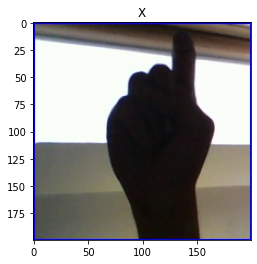

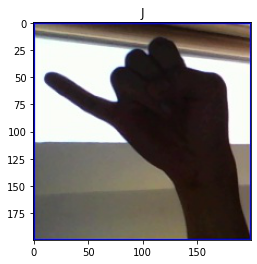

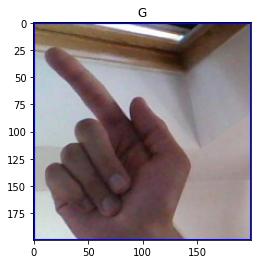

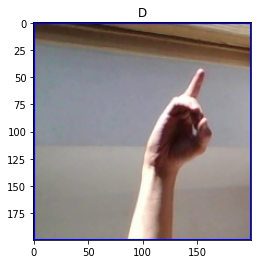

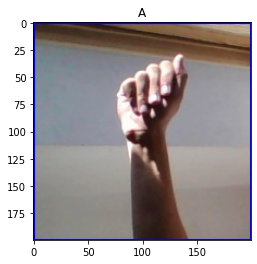

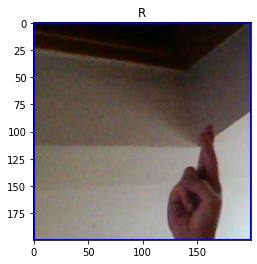

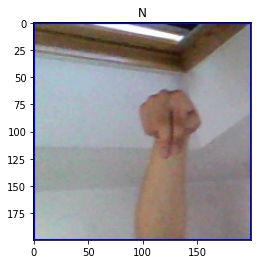

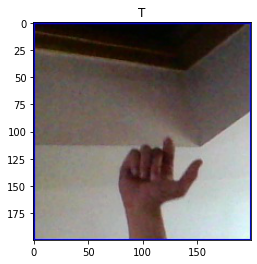

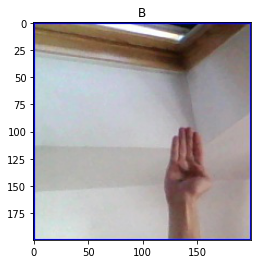

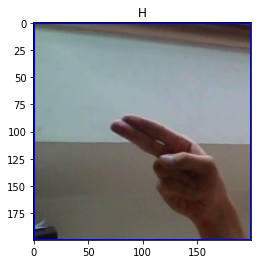

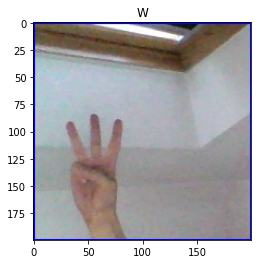

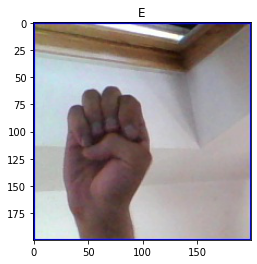

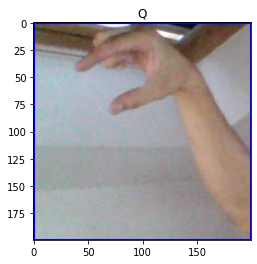

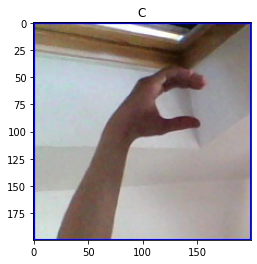

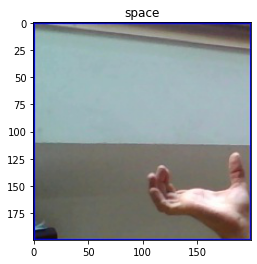

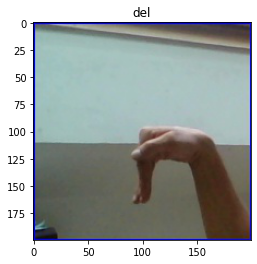

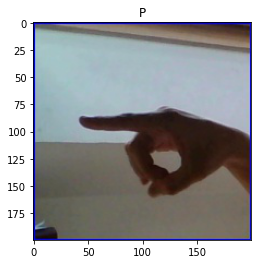

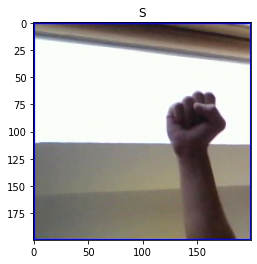

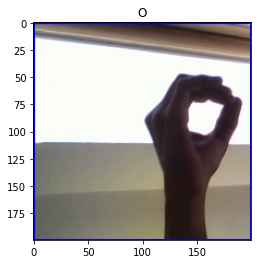

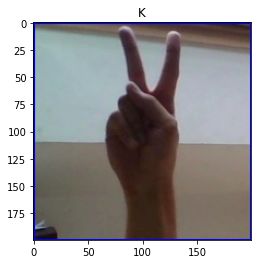

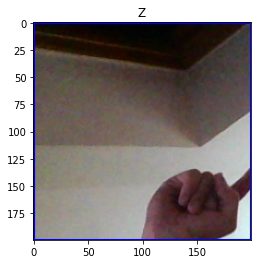

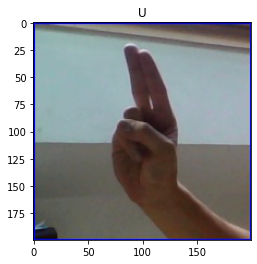

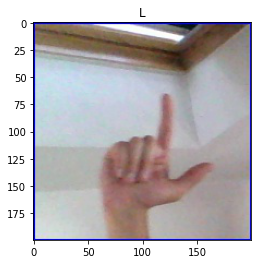

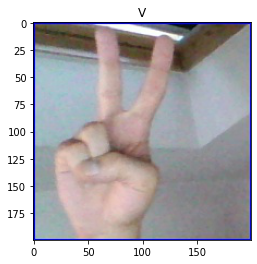

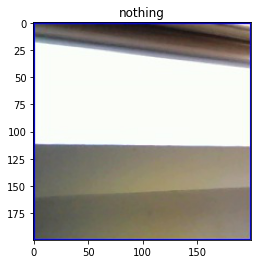

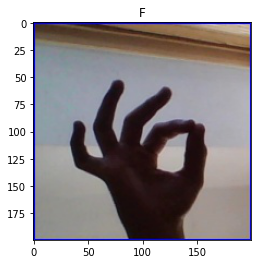

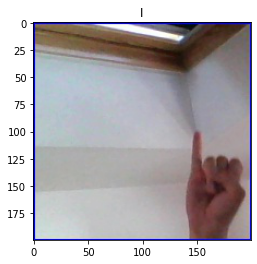

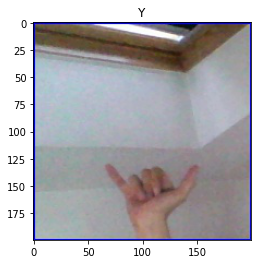

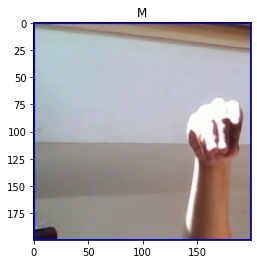

In [ ]:
# viewing random images of each label from train dataframe

unique_asl_signs = train_data_df['label'].unique().tolist()
images = []

for sign in unique_asl_signs:
    rows = train_data_df[train_data_df['label']==sign]['path']
    random_pick = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_pick]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(sign)
    plt.imshow(img)

In [ ]:
# viewing number of images in train dataset, validation dataset and test dataset
print(f'training data size: {len(train_data_df)}')
print(f'validation data size: {len(val_data_df)}')
print(f'testing data size: {len(test_data_df)}')

training data size: 60914
validation data size: 8702
testing data size: 17404


###**Creating image data generators for train, validation and test image dataset to feed the images to training models in batches**

In [ ]:
# creating image data generators

# defining image dimensions, batch size, target size of image, target dimensions and number of labels
img_dim = 64
batch_size = 64
target_size = (img_dim, img_dim)
target_dims = (img_dim, img_dim, 3)
num_classes = len(train_data_df['label'].unique())

# images are normalized, but not augmented

# train image generator
train_datagen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data_df,x_col='path', y_col='label', target_size=(img_dim, img_dim),class_mode='categorical', batch_size=batch_size, shuffle=False)

# validation image generator
validation_datagen = ImageDataGenerator(rescale = 1/255.0,horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)

# testing image generator
test_datagen = ImageDataGenerator(rescale = 1/255.0,horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 60914 validated image filenames belonging to 29 classes.
Found 8702 validated image filenames belonging to 29 classes.
Found 17404 validated image filenames belonging to 29 classes.


## **CNN Models with 1 Convolutional layer, 1 Maxpooling layer and 1 Dropout layer**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_1l = Sequential()

model_1_1l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_1l.add(Activation('relu'))
model_1_1l.add(MaxPooling2D((2, 2)))
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Flatten())
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Dense(128, activation='relu'))

model_1_1l.add(Dense(num_classes, activation='softmax'))

model_1_1l.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 28800)             0         
                                                        

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 87s 82ms/step - loss: 3.3803 - accuracy: 0.0398 - val_loss: 3.2869 - val_accuracy: 0.1173
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 3.1117 - accuracy: 0.1318 - val_loss: 2.6053 - val_accuracy: 0.2362
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 2.4176 - accuracy: 0.2653 - val_loss: 2.0870 - val_accuracy: 0.3558
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 2.0540 - accuracy: 0.3573 - val_loss: 1.6477 - val_accuracy: 0.5061
Epoch 5/10
952/952 [==============================] - 79s 83ms/step - loss: 1.7886 - accuracy: 0.4380 - val_loss: 1.4948 - val_accuracy: 0.5132
Epoch 6/10
952/952 [==============================] - 79s 83ms/step - loss: 1.5717 - accuracy: 0.4998 - val_loss: 1.2307 - val_accuracy: 0.6216
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 1.3949 - accuracy: 0.5507 - val_loss: 1.1790 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.380277  0.039843  3.286940      0.117329
1  3.111658  0.131792  2.605336      0.236153
2  2.417623  0.265341  2.087016      0.355780
3  2.054004  0.357340  1.647711      0.506091
4  1.788605  0.437962  1.494789      0.513215
5  1.571702  0.499754  1.230671      0.621581
6  1.394932  0.550662  1.178975      0.636176
7  1.260153  0.591096  0.979859      0.707194
8  1.159332  0.625193  0.862046      0.734429
9  1.070638  0.648734  0.801488      0.741439

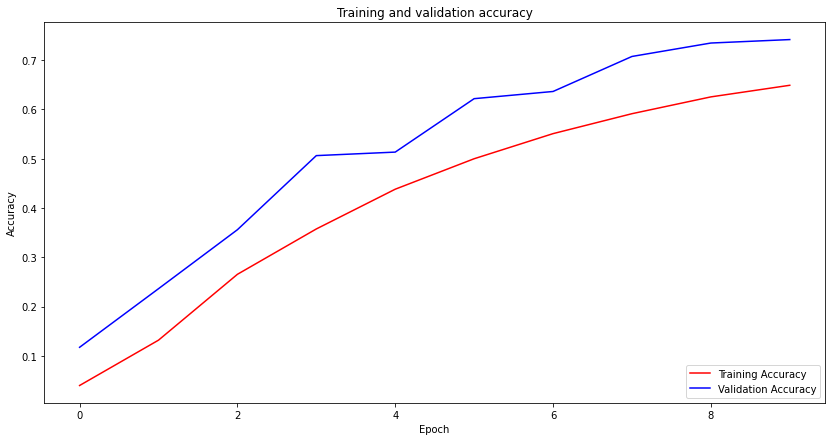

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_1l.history.history['accuracy']
val_acc= model_1_1l.history.history['val_accuracy']
loss= model_1_1l.history.history['loss']
val_loss= model_1_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

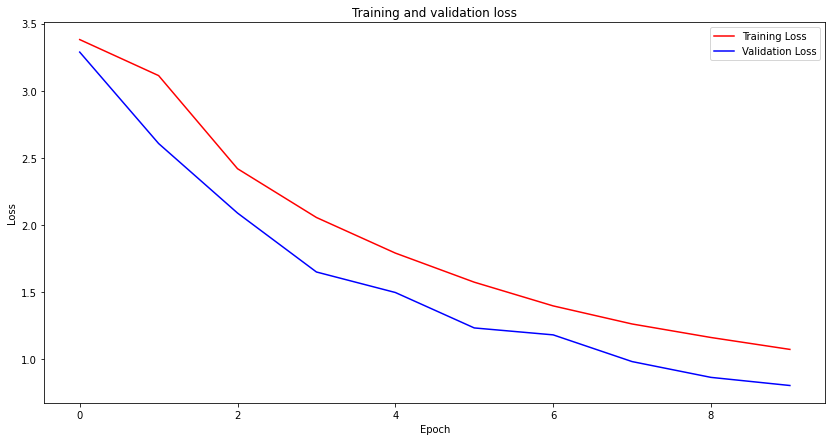

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 0.8061 - accuracy: 0.7364
loss : 0.8061171770095825 acc : 0.7363824248313904


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.98      0.31      0.47       600
           B       0.82      0.81      0.81       600
           C       0.99      0.94      0.97       600
           D       0.73      0.94      0.82       600
           E       0.50      0.80      0.61       600
           F       0.88      0.89      0.88       600
           G       0.82      0.87      0.84       600
           H       0.87      0.89      0.88       600
           I       0.84      0.86      0.85       602
           J       0.96      0.86      0.91       600
           K       0.84      0.90      0.86       600
           L       0.98      0.76      0.86       600
           M       0.55      0.83      0.66       600
           N       0.97      0.40      0.57       602
           O       0.86      0.70      0.77       600
           P       0.79      0.86      0.82       600
           Q       0.85 

<Figure size 3600x3600 with 0 Axes>

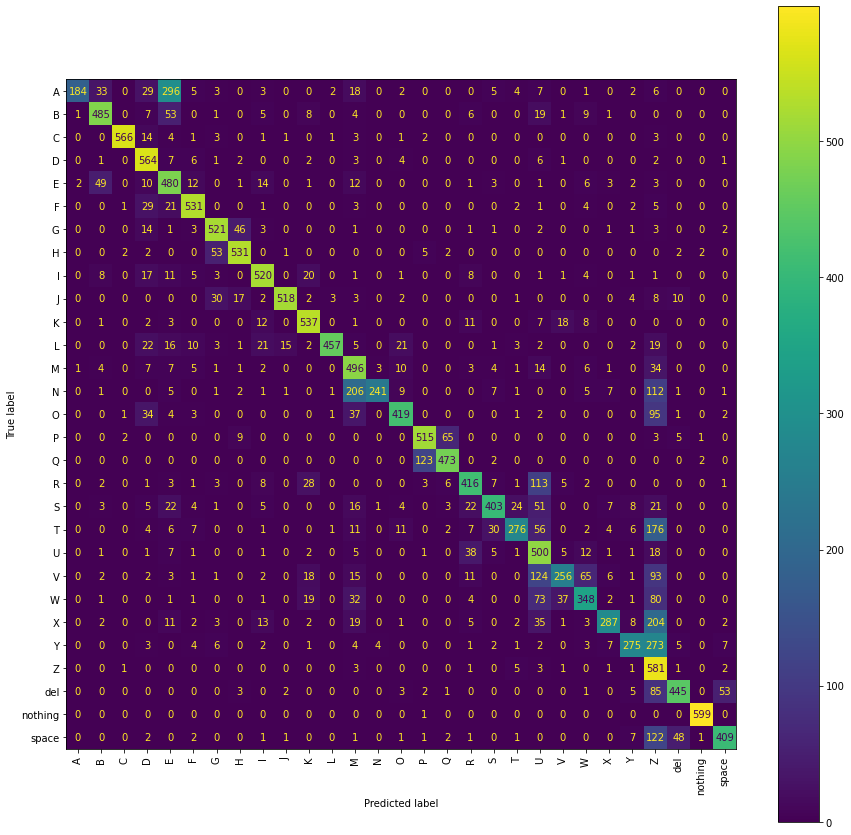

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_1l = Sequential()

model_2_1l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_1l.add(Activation('relu'))
model_2_1l.add(MaxPooling2D((2, 2)))
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Flatten())
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Dense(128, activation='relu'))

model_2_1l.add(Dense(num_classes, activation='softmax'))

model_2_1l.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_1 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_3 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3820 - accuracy: 0.0297 - val_loss: 3.3670 - val_accuracy: 0.0373
Epoch 2/10
952/952 [==============================] - 78s 81ms/step - loss: 3.3477 - accuracy: 0.0394 - val_loss: 3.2461 - val_accuracy: 0.0817
Epoch 3/10
952/952 [==============================] - 79s 83ms/step - loss: 3.1119 - accuracy: 0.1236 - val_loss: 2.7821 - val_accuracy: 0.2116
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 2.7170 - accuracy: 0.2098 - val_loss: 2.3631 - val_accuracy: 0.3091
Epoch 5/10
952/952 [==============================] - 77s 81ms/step - loss: 2.3829 - accuracy: 0.2831 - val_loss: 2.1320 - val_accuracy: 0.3503
Epoch 6/10
952/952 [==============================] - 77s 81ms/step - loss: 2.0481 - accuracy: 0.3693 - val_loss: 1.7060 - val_accuracy: 0.4945
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 1.8011 - accuracy: 0.4383 - val_loss: 1.4841 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.382006  0.029681  3.367043      0.037348
1  3.347718  0.039351  3.246131      0.081705
2  3.111937  0.123568  2.782077      0.211561
3  2.716980  0.209820  2.363087      0.309124
4  2.382936  0.283055  2.131984      0.350264
5  2.048145  0.369258  1.705972      0.494484
6  1.801081  0.438323  1.484099      0.548150
7  1.635664  0.488361  1.311880      0.598483
8  1.494522  0.528417  1.184244      0.632383
9  1.373689  0.561808  1.096538      0.664330

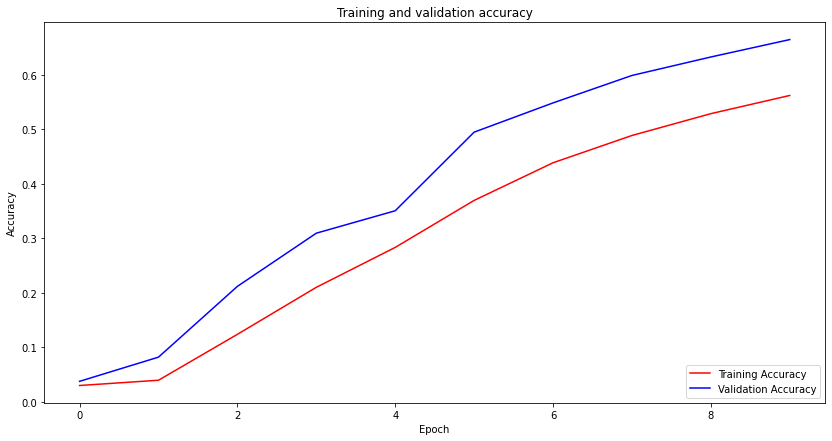

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_1l.history.history['accuracy']
val_acc= model_2_1l.history.history['val_accuracy']
loss= model_2_1l.history.history['loss']
val_loss= model_2_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

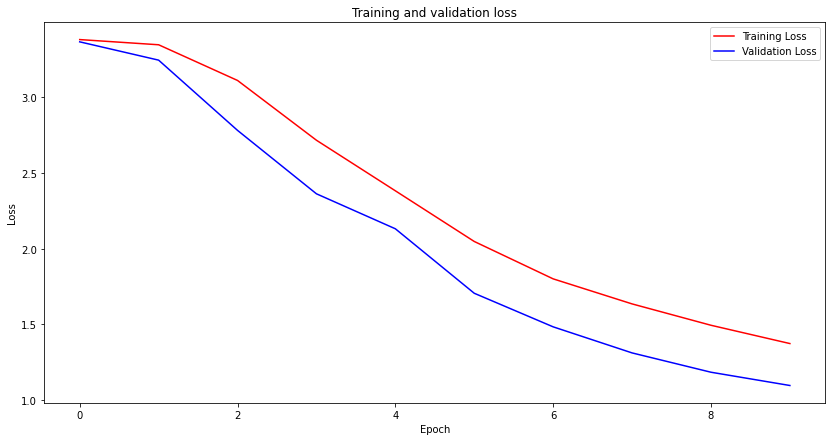

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 71ms/step - loss: 1.0926 - accuracy: 0.6636
loss : 1.0925674438476562 acc : 0.6635830998420715


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.64      0.73      0.68       600
           B       0.66      0.80      0.72       600
           C       0.97      0.91      0.94       600
           D       0.76      0.83      0.79       600
           E       0.67      0.57      0.62       600
           F       0.74      0.87      0.80       600
           G       0.73      0.89      0.80       600
           H       0.91      0.77      0.83       600
           I       0.89      0.68      0.77       602
           J       0.85      0.84      0.85       600
           K       0.69      0.86      0.77       600
           L       0.99      0.56      0.72       600
           M       0.47      0.77      0.59       600
           N       0.92      0.48      0.63       602
           O       0.73      0.51      0.60       600
           P       0.92      0.55      0.69       600
           Q       0.69 

<Figure size 3600x3600 with 0 Axes>

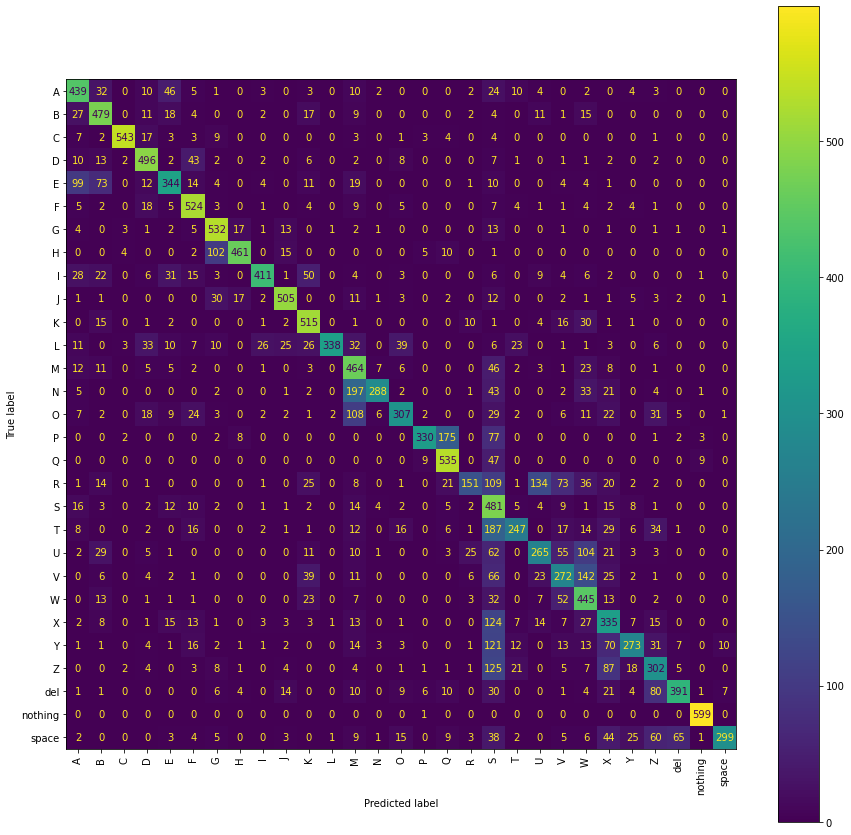

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_1l = Sequential()

model_3_1l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_1l.add(Activation('relu'))
model_3_1l.add(MaxPooling2D((2, 2)))
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Flatten())
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Dense(128, activation='relu'))

model_3_1l.add(Dense(num_classes, activation='softmax'))

model_3_1l.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_2 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_5 (Dropout)         (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 78s 81ms/step - loss: 3.3527 - accuracy: 0.0565 - val_loss: 3.1672 - val_accuracy: 0.1619
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 2.7966 - accuracy: 0.1957 - val_loss: 2.2671 - val_accuracy: 0.3151
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 2.1166 - accuracy: 0.3478 - val_loss: 1.7023 - val_accuracy: 0.4813
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 1.7169 - accuracy: 0.4606 - val_loss: 1.3843 - val_accuracy: 0.5748
Epoch 5/10
952/952 [==============================] - 79s 83ms/step - loss: 1.4641 - accuracy: 0.5305 - val_loss: 1.1429 - val_accuracy: 0.6427
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 1.2645 - accuracy: 0.5889 - val_loss: 0.9535 - val_accuracy: 0.6936
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 1.1078 - accuracy: 0.6380 - val_loss: 0.8782 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.352693  0.056473  3.167175      0.161917
1  2.796617  0.195719  2.267085      0.315100
2  2.116609  0.347753  1.702261      0.481269
3  1.716901  0.460551  1.384273      0.574810
4  1.464129  0.530502  1.142889      0.642726
5  1.264464  0.588879  0.953510      0.693634
6  1.107796  0.638014  0.878241      0.718800
7  0.997822  0.670486  0.744902      0.759251
8  0.918804  0.694356  0.653700      0.799127
9  0.846548  0.719342  0.592301      0.818777

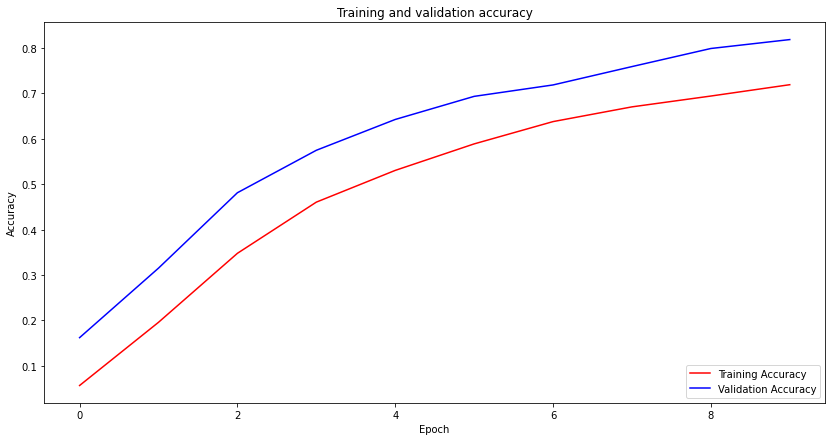

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_1l.history.history['accuracy']
val_acc= model_3_1l.history.history['val_accuracy']
loss= model_3_1l.history.history['loss']
val_loss= model_3_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

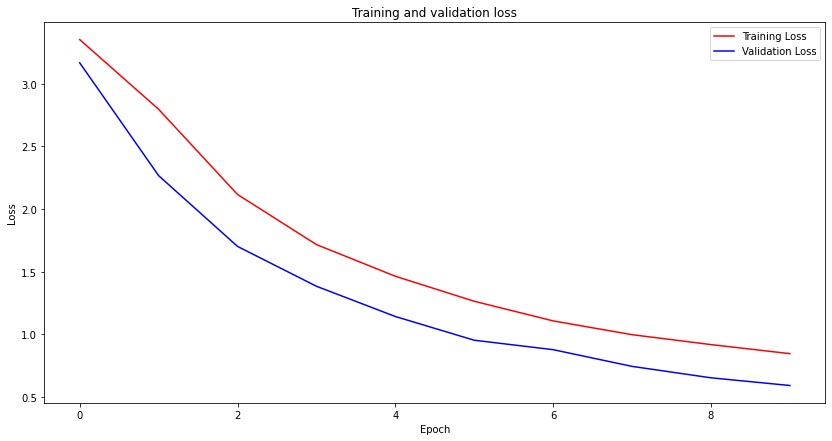

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 0.5920 - accuracy: 0.8172
loss : 0.591978132724762 acc : 0.8171684741973877


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 20s 72ms/step
              precision    recall  f1-score   support

           A       0.77      0.85      0.81       600
           B       0.81      0.95      0.88       600
           C       0.97      0.97      0.97       600
           D       0.91      0.94      0.93       600
           E       0.85      0.69      0.76       600
           F       0.98      0.92      0.95       600
           G       0.92      0.89      0.90       600
           H       0.85      0.96      0.90       600
           I       0.94      0.85      0.89       602
           J       0.98      0.79      0.88       600
           K       0.95      0.87      0.91       600
           L       0.87      0.96      0.91       600
           M       0.63      0.89      0.74       600
           N       0.90      0.80      0.85       602
           O       0.94      0.78      0.85       600
           P       0.68      0.97      0.80       600
           Q       0.98 

<Figure size 3600x3600 with 0 Axes>

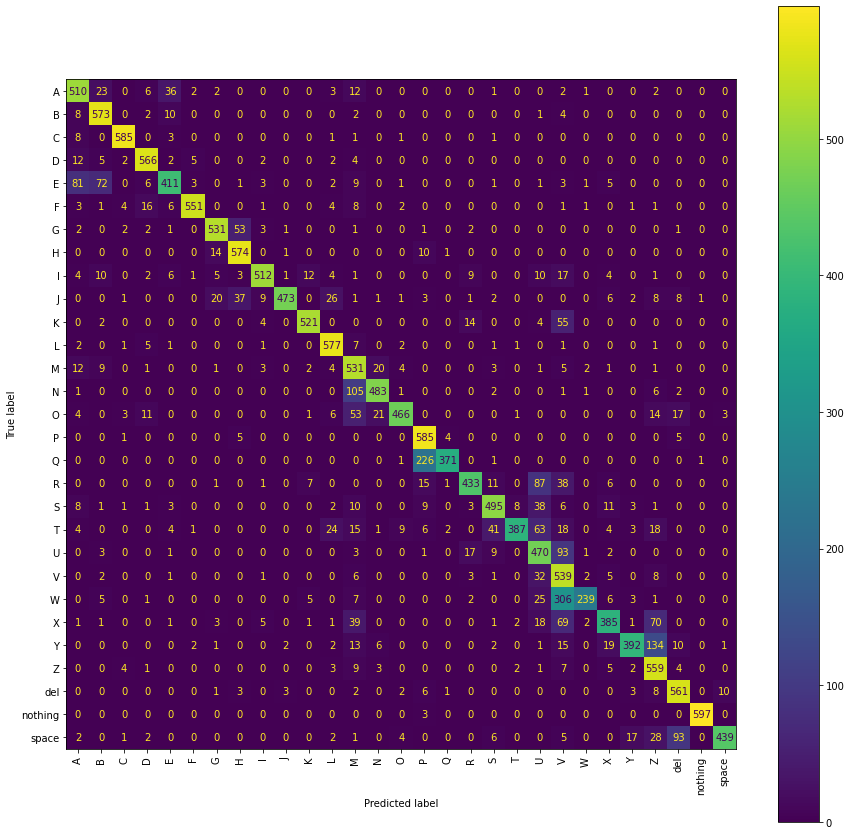

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_1l = Sequential()

model_4_1l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_1l.add(Activation('relu'))
model_4_1l.add(MaxPooling2D((2, 2)))
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Flatten())
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Dense(128, activation='relu'))

model_4_1l.add(Dense(num_classes, activation='softmax'))

model_4_1l.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_3 (Activation)   (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_7 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 79s 82ms/step - loss: 3.3568 - accuracy: 0.0454 - val_loss: 3.2267 - val_accuracy: 0.1166
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 2.9255 - accuracy: 0.1672 - val_loss: 2.3891 - val_accuracy: 0.2812
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 2.2708 - accuracy: 0.3093 - val_loss: 1.9006 - val_accuracy: 0.4182
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 1.9125 - accuracy: 0.4057 - val_loss: 1.5615 - val_accuracy: 0.5362
Epoch 5/10
952/952 [==============================] - 78s 82ms/step - loss: 1.6736 - accuracy: 0.4766 - val_loss: 1.4227 - val_accuracy: 0.5494
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 1.4918 - accuracy: 0.5248 - val_loss: 1.1508 - val_accuracy: 0.6649
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 1.3629 - accuracy: 0.5612 - val_loss: 1.0191 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.356806  0.045408  3.226717      0.116640
1  2.925469  0.167203  2.389074      0.281200
2  2.270822  0.309256  1.900571      0.418180
3  1.912493  0.405720  1.561527      0.536199
4  1.673606  0.476557  1.422691      0.549414
5  1.491779  0.524838  1.150849      0.664905
6  1.362944  0.561152  1.019117      0.700988
7  1.245595  0.598811  0.944978      0.710986
8  1.148004  0.628000  0.884755      0.718570
9  1.087937  0.646403  0.767742      0.771777

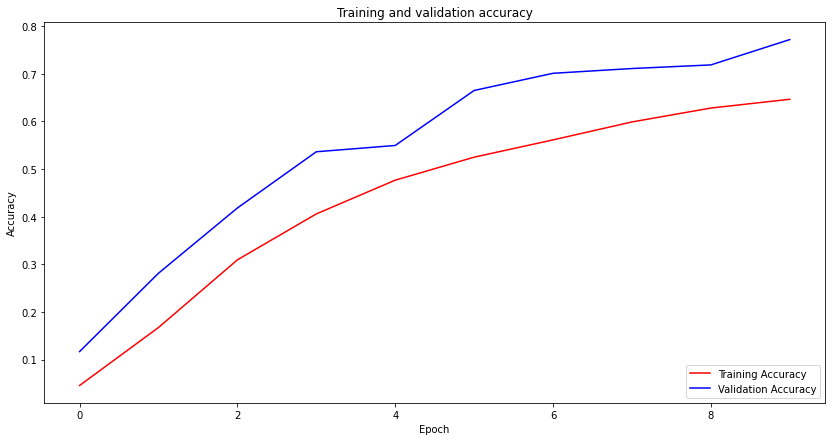

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_1l.history.history['accuracy']
val_acc= model_4_1l.history.history['val_accuracy']
loss= model_4_1l.history.history['loss']
val_loss= model_4_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

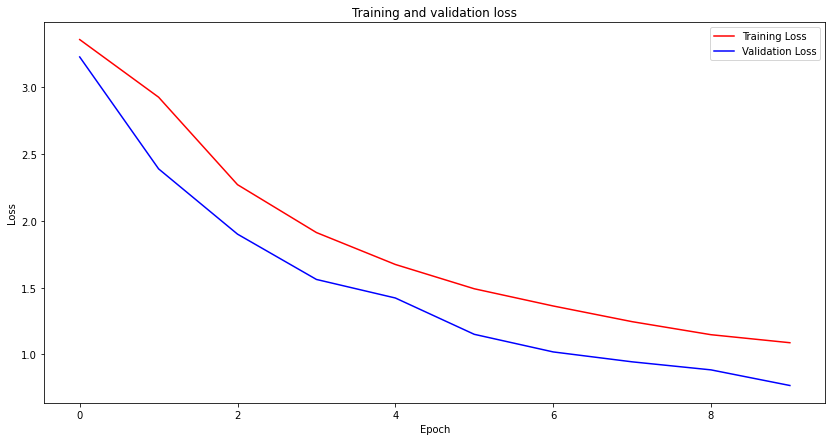

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 73ms/step - loss: 0.7703 - accuracy: 0.7691
loss : 0.7703068256378174 acc : 0.7690760493278503


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 20s 72ms/step
              precision    recall  f1-score   support

           A       0.74      0.84      0.79       600
           B       0.82      0.83      0.82       600
           C       0.96      0.95      0.96       600
           D       0.91      0.83      0.87       600
           E       0.89      0.60      0.72       600
           F       0.76      0.95      0.85       600
           G       0.93      0.83      0.88       600
           H       0.88      0.92      0.90       600
           I       0.92      0.85      0.89       602
           J       0.86      0.94      0.90       600
           K       0.79      0.91      0.84       600
           L       0.91      0.90      0.91       600
           M       0.64      0.81      0.71       600
           N       0.79      0.82      0.81       602
           O       0.98      0.53      0.68       600
           P       0.67      0.95      0.79       600
           Q       0.92 

<Figure size 3600x3600 with 0 Axes>

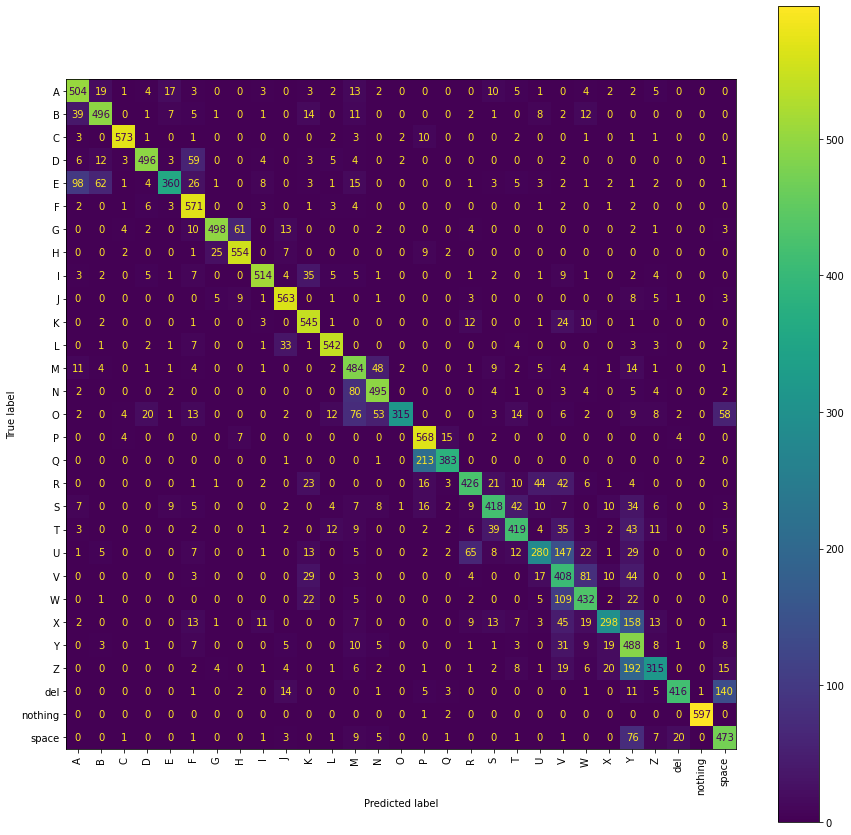

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_1l = Sequential()

model_5_1l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_1l.add(Activation('relu'))
model_5_1l.add(MaxPooling2D((2, 2)))
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Flatten())
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Dense(128, activation='relu'))

model_5_1l.add(Dense(num_classes, activation='softmax'))

model_5_1l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 57, 57, 32)        6176      
                                                                 
 activation_4 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3797 - accuracy: 0.0275 - val_loss: 3.3429 - val_accuracy: 0.0500
Epoch 2/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3132 - accuracy: 0.0512 - val_loss: 3.2316 - val_accuracy: 0.1050
Epoch 3/10
952/952 [==============================] - 79s 83ms/step - loss: 3.1849 - accuracy: 0.1127 - val_loss: 2.9961 - val_accuracy: 0.1553
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 2.9805 - accuracy: 0.1553 - val_loss: 2.6869 - val_accuracy: 0.2355
Epoch 5/10
952/952 [==============================] - 78s 82ms/step - loss: 2.7349 - accuracy: 0.2073 - val_loss: 2.4370 - val_accuracy: 0.2779
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 2.5260 - accuracy: 0.2498 - val_loss: 2.1553 - val_accuracy: 0.3651
Epoch 7/10
952/952 [==============================] - 79s 83ms/step - loss: 2.3258 - accuracy: 0.3033 - val_loss: 2.0562 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.379742  0.027481  3.342884      0.049989
1  3.313232  0.051236  3.231599      0.105033
2  3.184927  0.112683  2.996115      0.155252
3  2.980527  0.155268  2.686850      0.235463
4  2.734940  0.207276  2.436967      0.277867
5  2.526042  0.249828  2.155280      0.365088
6  2.325809  0.303296  2.056194      0.369800
7  2.177108  0.339331  1.801757      0.455183
8  2.014052  0.384165  1.689629      0.484831
9  1.890597  0.417901  1.548020      0.524017

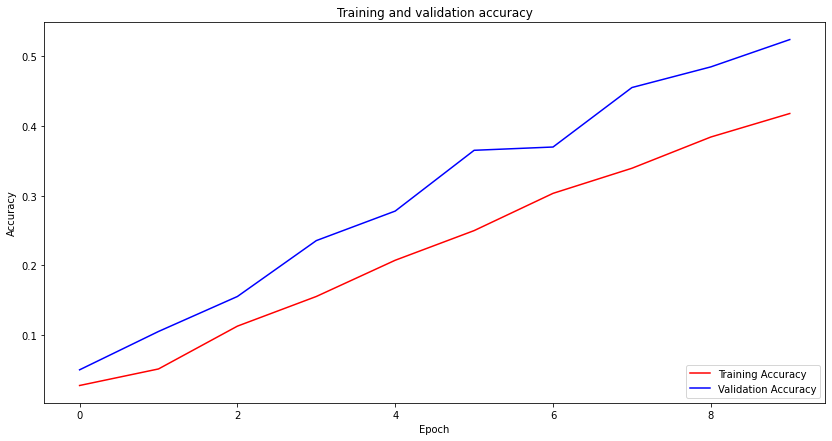

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_1l.history.history['accuracy']
val_acc= model_5_1l.history.history['val_accuracy']
loss= model_5_1l.history.history['loss']
val_loss= model_5_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

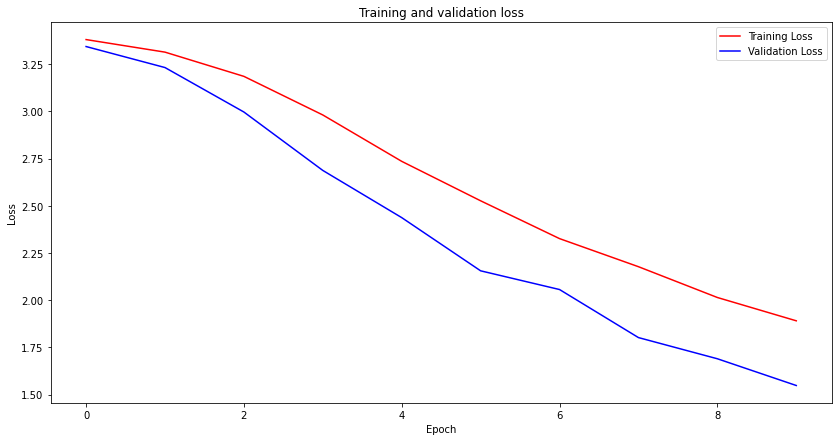

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 73ms/step - loss: 1.5609 - accuracy: 0.5260
loss : 1.5609008073806763 acc : 0.5260285139083862


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 20s 72ms/step
              precision    recall  f1-score   support

           A       0.56      0.58      0.57       600
           B       0.67      0.64      0.65       600
           C       0.70      0.93      0.80       600
           D       0.73      0.67      0.70       600
           E       0.45      0.50      0.48       600
           F       0.64      0.83      0.72       600
           G       0.70      0.52      0.60       600
           H       0.60      0.89      0.72       600
           I       0.59      0.46      0.51       602
           J       0.66      0.68      0.67       600
           K       0.50      0.69      0.58       600
           L       0.77      0.48      0.59       600
           M       0.76      0.24      0.37       600
           N       0.47      0.61      0.53       602
           O       0.62      0.49      0.55       600
           P       0.27      0.67      0.38       600
           Q       0.33 

<Figure size 3600x3600 with 0 Axes>

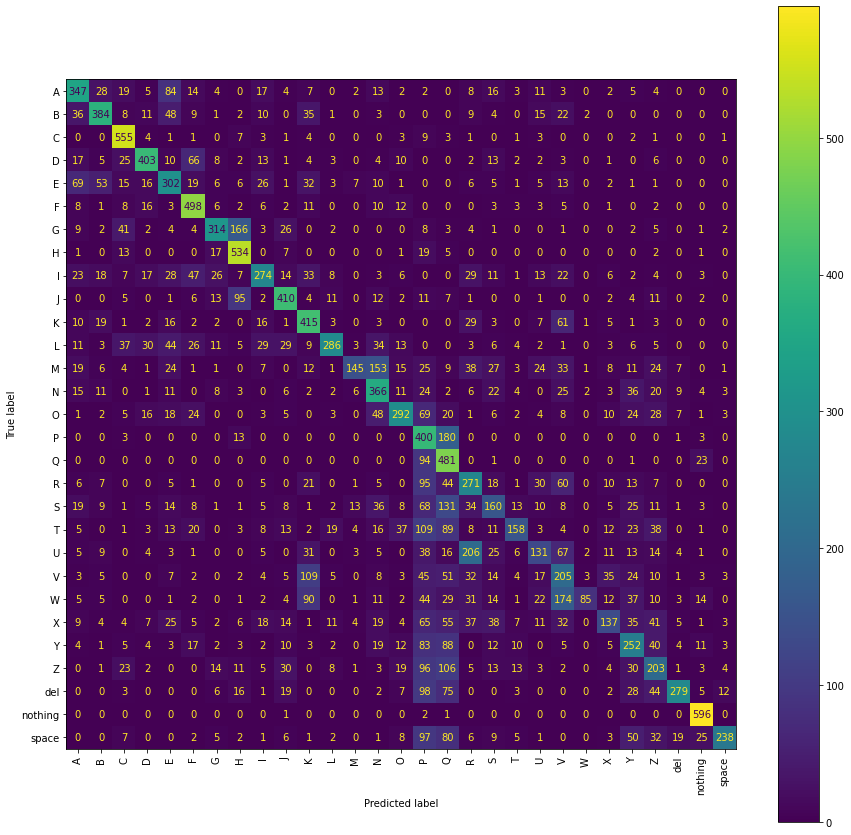

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

## **CNN Models with 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_2l = Sequential()

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Flatten())
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Dense(128, activation='relu'))

model_1_2l.add(Dense(num_classes, activation='softmax'))

model_1_2l.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_5 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        25632     
                                                                 
 activation_6 (Activation)   (None, 26, 26, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3747 - accuracy: 0.0176 - val_loss: 3.3667 - val_accuracy: 0.0399
Epoch 2/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3723 - accuracy: 0.0241 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3748 - accuracy: 0.0251 - val_loss: 3.3590 - val_accuracy: 0.0453
Epoch 4/10
952/952 [==============================] - 77s 81ms/step - loss: 3.2704 - accuracy: 0.0680 - val_loss: 3.1510 - val_accuracy: 0.1286
Epoch 5/10
952/952 [==============================] - 77s 81ms/step - loss: 2.9120 - accuracy: 0.1641 - val_loss: 2.5284 - val_accuracy: 0.2706
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 2.4429 - accuracy: 0.2626 - val_loss: 2.0906 - val_accuracy: 0.3945
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 2.1062 - accuracy: 0.3475 - val_loss: 1.8660 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.374702  0.017631  3.366672      0.039876
1  3.372281  0.024149  3.367539      0.034475
2  3.374831  0.025068  3.358977      0.045277
3  3.270434  0.067998  3.150991      0.128591
4  2.911997  0.164117  2.528398      0.270627
5  2.442868  0.262600  2.090564      0.394507
6  2.106200  0.347490  1.865964      0.433923
7  1.850282  0.415077  1.415974      0.556539
8  1.658444  0.470417  1.268785      0.615146
9  1.493727  0.517057  1.127737      0.634912

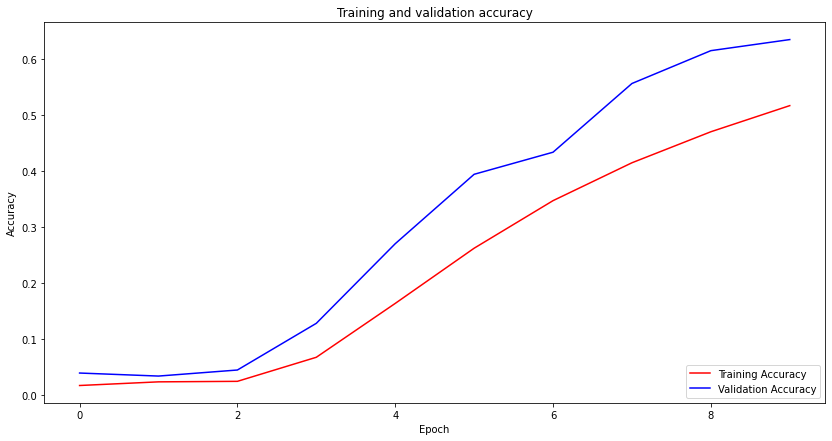

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_2l.history.history['accuracy']
val_acc= model_1_2l.history.history['val_accuracy']
loss= model_1_2l.history.history['loss']
val_loss= model_1_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

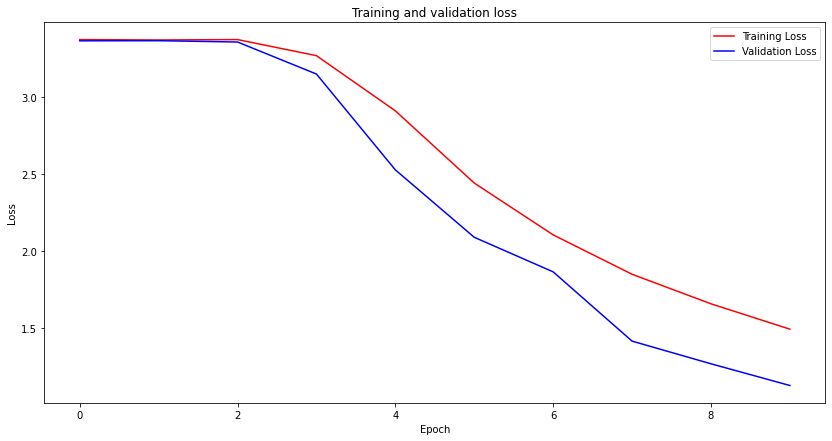

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 71ms/step - loss: 1.1335 - accuracy: 0.6315
loss : 1.133451223373413 acc : 0.631521463394165


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.76      0.47      0.58       600
           B       0.52      0.89      0.65       600
           C       0.98      0.93      0.95       600
           D       0.86      0.72      0.78       600
           E       0.62      0.48      0.54       600
           F       0.78      0.88      0.82       600
           G       0.91      0.66      0.77       600
           H       0.89      0.83      0.86       600
           I       0.69      0.61      0.65       602
           J       0.80      0.84      0.82       600
           K       0.43      0.91      0.58       600
           L       0.74      0.89      0.81       600
           M       0.79      0.37      0.51       600
           N       0.78      0.55      0.64       602
           O       0.77      0.76      0.76       600
           P       0.83      0.64      0.72       600
           Q       0.76 

<Figure size 3600x3600 with 0 Axes>

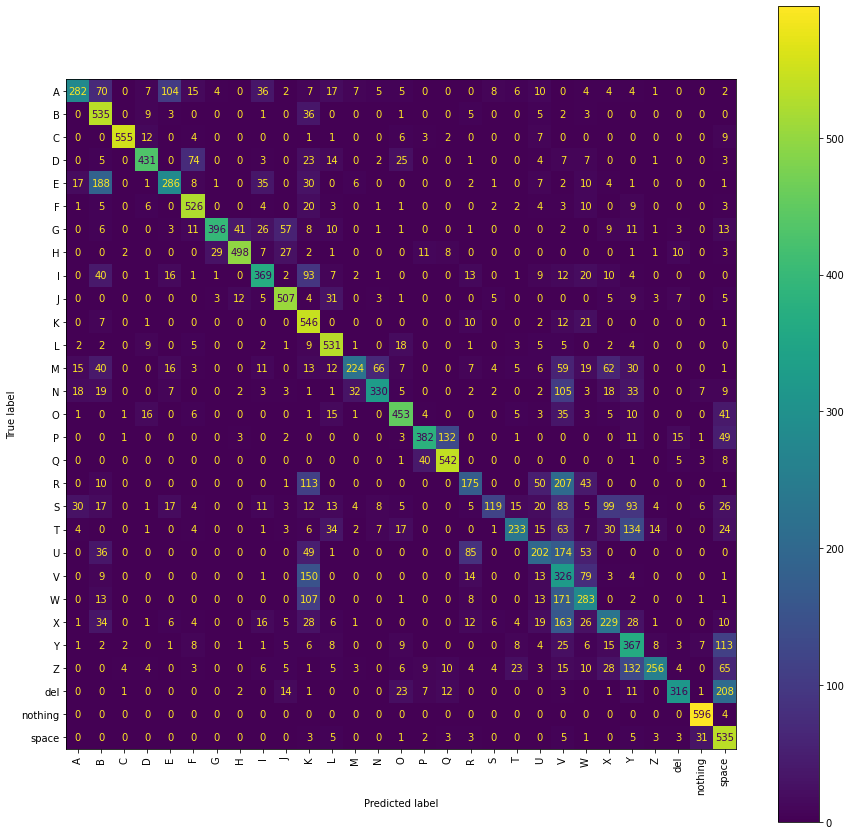

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_2l = Sequential()

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Flatten())
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Dense(128, activation='relu'))

model_2_2l.add(Dense(num_classes, activation='softmax'))

model_2_2l.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_7 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 32)        50208     
                                                                 
 activation_8 (Activation)   (None, 23, 23, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3755 - accuracy: 0.0213 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3701 - accuracy: 0.0151 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3723 - accuracy: 0.0239 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3726 - accuracy: 0.0278 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3698 - accuracy: 0.0254 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 79s 83ms/step - loss: 3.3630 - accuracy: 0.0278 - val_loss: 3.3177 - val_accuracy: 0.0439
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 3.2843 - accuracy: 0.0610 - val_loss: 3.2116 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.375516  0.021309  3.367406      0.034475
1  3.370076  0.015087  3.367373      0.034475
2  3.372292  0.023870  3.367359      0.034475
3  3.372560  0.027793  3.367367      0.034475
4  3.369806  0.025446  3.367343      0.034475
5  3.363046  0.027777  3.317731      0.043898
6  3.284276  0.061037  3.211557      0.089635
7  3.141096  0.110976  3.039747      0.155022
8  2.980430  0.147437  2.864149      0.190646
9  2.821862  0.182273  2.730794      0.212940

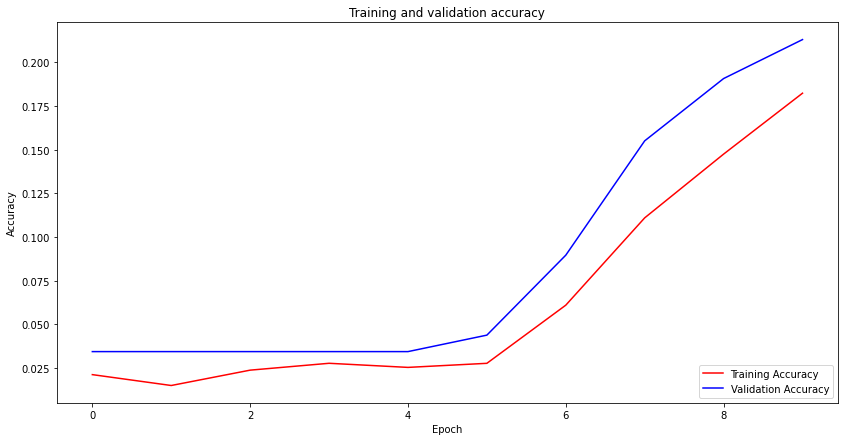

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_2l.history.history['accuracy']
val_acc= model_2_2l.history.history['val_accuracy']
loss= model_2_2l.history.history['loss']
val_loss= model_2_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

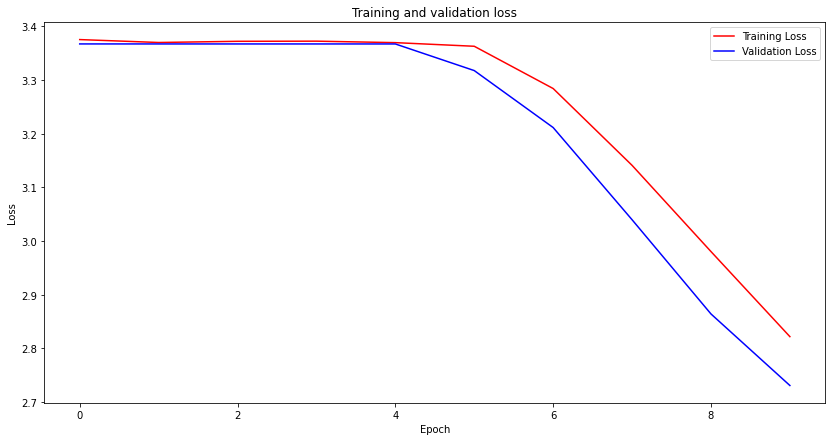

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 2.7354 - accuracy: 0.2059
loss : 2.7354390621185303 acc : 0.20587220788002014


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.36      0.13      0.19       600
           B       0.18      0.44      0.26       600
           C       0.68      0.69      0.69       600
           D       0.59      0.23      0.33       600
           E       0.16      0.17      0.16       600
           F       0.70      0.28      0.40       600
           G       0.46      0.15      0.22       600
           H       0.35      0.28      0.32       600
           I       0.20      0.07      0.10       602
           J       0.36      0.10      0.16       600
           K       0.11      0.29      0.15       600
           L       0.62      0.05      0.10       600
           M       0.08      0.18      0.11       600
           N       0.24      0.11      0.15       602
           O       0.57      0.10      0.17       600
           P       0.40      0.38      0.39       600
           Q       0.53 

<Figure size 3600x3600 with 0 Axes>

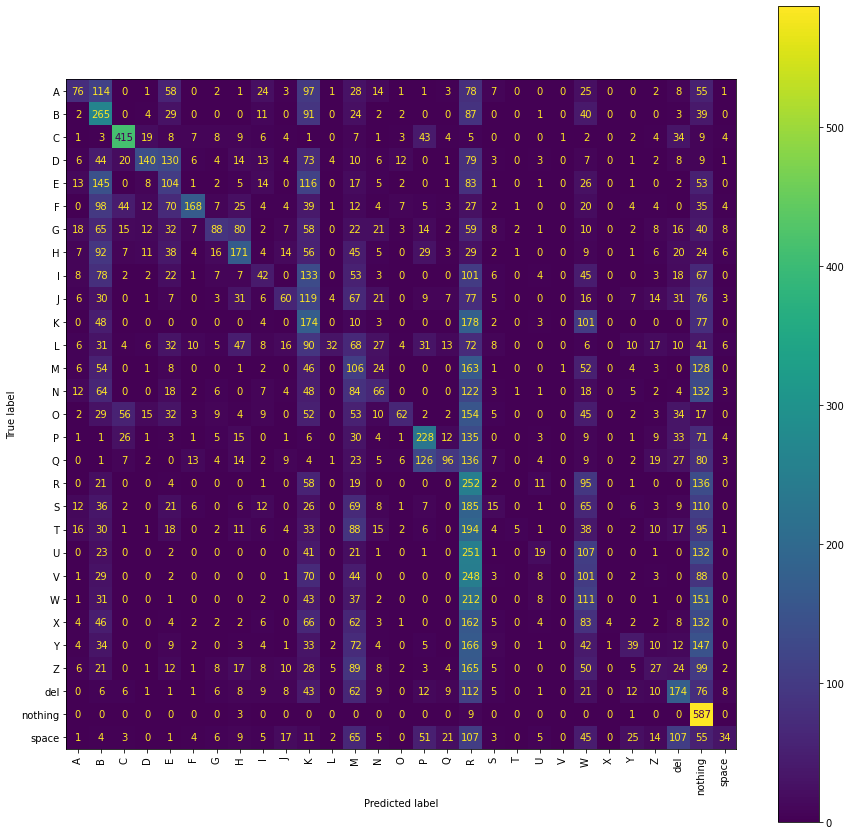

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_2l = Sequential()

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Flatten())
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Dense(128, activation='relu'))

model_3_2l.add(Dense(num_classes, activation='softmax'))

model_3_2l.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_9 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 32)        16416     
                                                                 
 activation_10 (Activation)  (None, 27, 27, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 79s 82ms/step - loss: 3.3768 - accuracy: 0.0256 - val_loss: 3.3580 - val_accuracy: 0.0456
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 3.2533 - accuracy: 0.0701 - val_loss: 2.9743 - val_accuracy: 0.1788
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 2.6990 - accuracy: 0.2083 - val_loss: 2.3496 - val_accuracy: 0.3305
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 2.2151 - accuracy: 0.3299 - val_loss: 1.8891 - val_accuracy: 0.4301
Epoch 5/10
952/952 [==============================] - 78s 82ms/step - loss: 1.9357 - accuracy: 0.4058 - val_loss: 1.6458 - val_accuracy: 0.5125
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 1.7118 - accuracy: 0.4675 - val_loss: 1.5865 - val_accuracy: 0.5085
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 1.5621 - accuracy: 0.5119 - val_loss: 1.2846 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.376822  0.025626  3.357975      0.045622
1  3.253276  0.070099  2.974251      0.178809
2  2.699032  0.208261  2.349610      0.330499
3  2.215142  0.329858  1.889097      0.430131
4  1.935679  0.405818  1.645783      0.512526
5  1.711842  0.467512  1.586501      0.508504
6  1.562147  0.511886  1.284603      0.614801
7  1.448790  0.541041  1.155300      0.659618
8  1.345461  0.573431  1.186732      0.638244
9  1.274901  0.595265  1.020221      0.693059

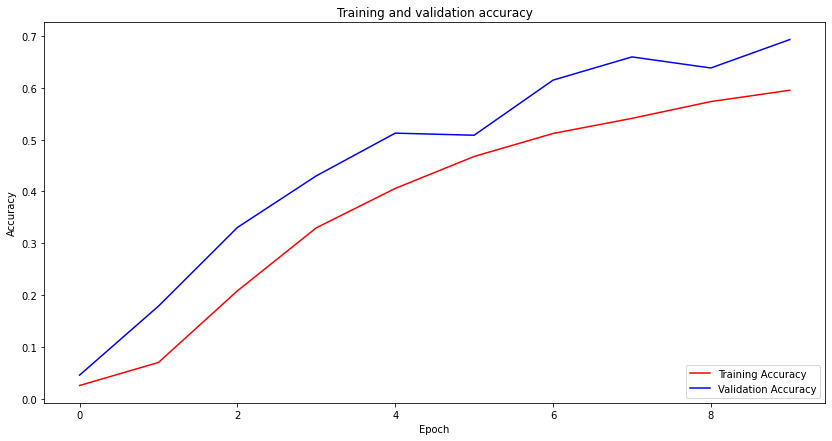

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_2l.history.history['accuracy']
val_acc= model_3_2l.history.history['val_accuracy']
loss= model_3_2l.history.history['loss']
val_loss= model_3_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

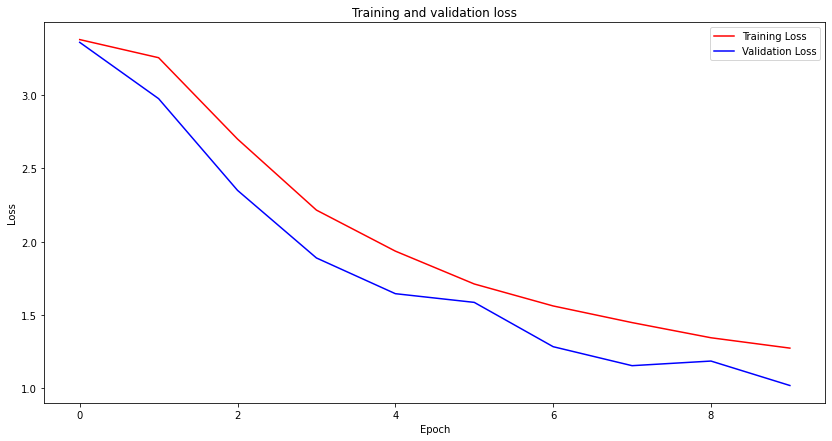

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 1.0173 - accuracy: 0.6907
loss : 1.0173412561416626 acc : 0.690703272819519


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 20s 72ms/step
              precision    recall  f1-score   support

           A       0.61      0.80      0.69       600
           B       0.81      0.71      0.76       600
           C       0.96      0.96      0.96       600
           D       0.86      0.86      0.86       600
           E       0.69      0.65      0.67       600
           F       0.88      0.90      0.89       600
           G       0.94      0.75      0.83       600
           H       0.88      0.89      0.89       600
           I       0.77      0.71      0.74       602
           J       0.90      0.86      0.88       600
           K       0.73      0.75      0.74       600
           L       0.78      0.93      0.85       600
           M       0.47      0.72      0.57       600
           N       0.76      0.73      0.75       602
           O       0.79      0.66      0.72       600
           P       0.62      0.90      0.73       600
           Q       0.93 

<Figure size 3600x3600 with 0 Axes>

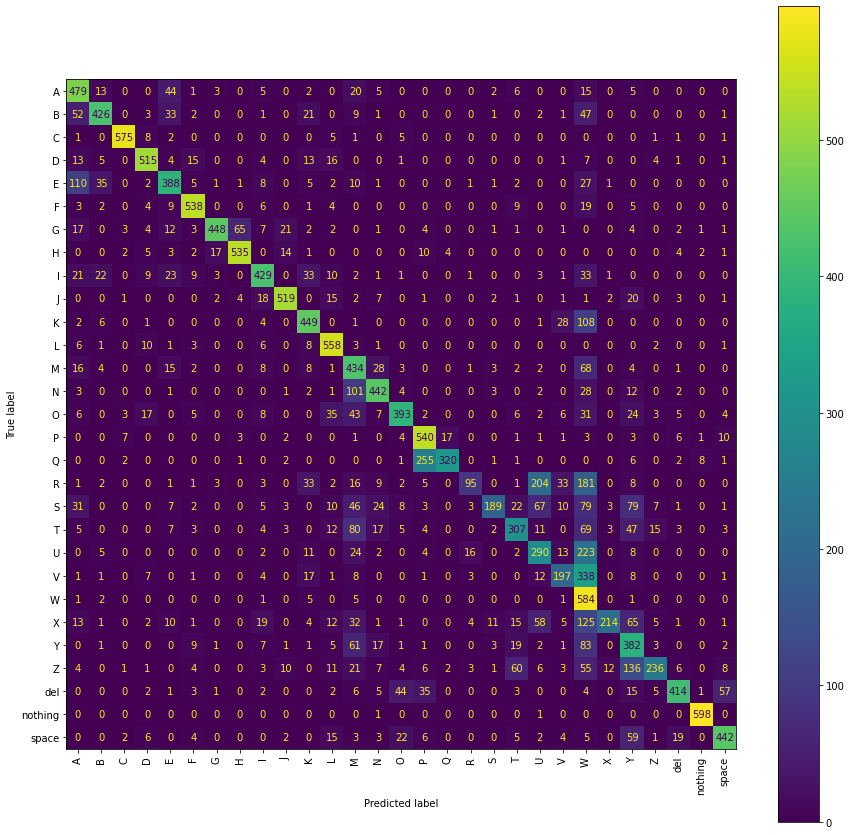

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_2l = Sequential()

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Flatten())
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Dense(128, activation='relu'))

model_4_2l.add(Dense(num_classes, activation='softmax'))

model_4_2l.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 59, 59, 32)        3488      
                                                                 
 activation_11 (Activation)  (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 32)        36896     
                                                                 
 activation_12 (Activation)  (None, 24, 24, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 79s 82ms/step - loss: 3.3736 - accuracy: 0.0263 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3702 - accuracy: 0.0213 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3896 - accuracy: 0.0221 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3705 - accuracy: 0.0222 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3700 - accuracy: 0.0200 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3698 - accuracy: 0.0257 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 78s 82ms/step - loss: 3.3698 - accuracy: 0.0189 - val_loss: 3.3673 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.373626  0.026349  3.367515      0.034475
1  3.370168  0.021276  3.367523      0.034475
2  3.389608  0.022097  3.367496      0.034475
3  3.370484  0.022244  3.367355      0.034475
4  3.370020  0.019963  3.367345      0.034475
5  3.369760  0.025725  3.367327      0.034475
6  3.369844  0.018879  3.367322      0.034475
7  3.369889  0.021161  3.367314      0.034475
8  3.369828  0.015924  3.367305      0.034475
9  3.369970  0.019158  3.367306      0.034475

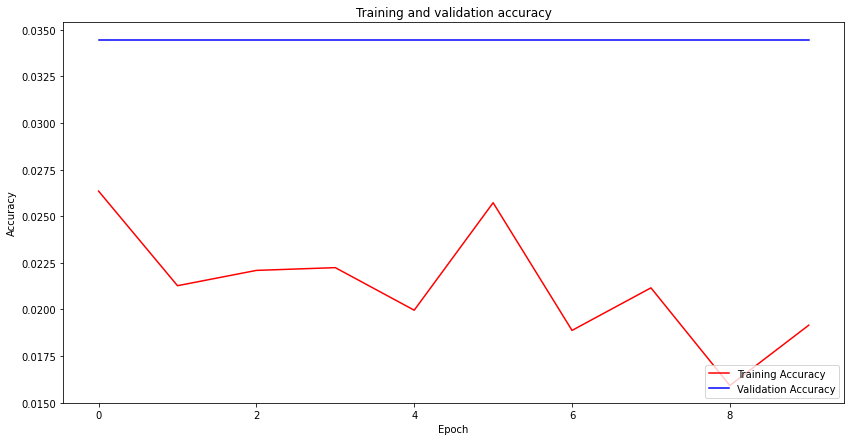

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_2l.history.history['accuracy']
val_acc= model_4_2l.history.history['val_accuracy']
loss= model_4_2l.history.history['loss']
val_loss= model_4_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

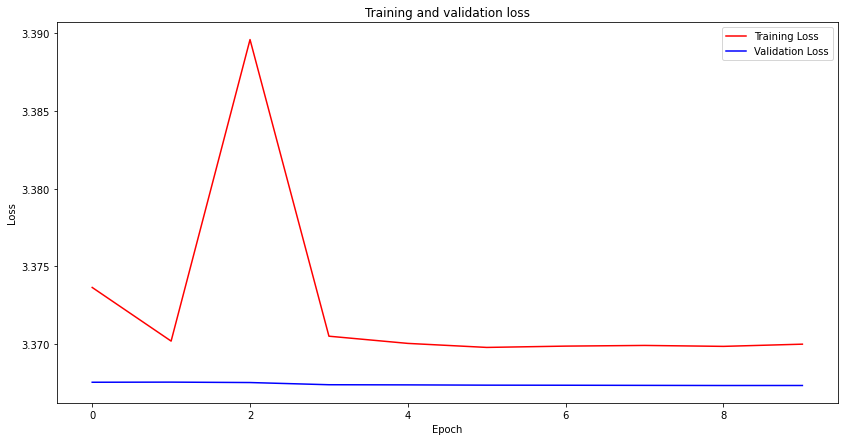

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 3.3673 - accuracy: 0.0345
loss : 3.367305040359497 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

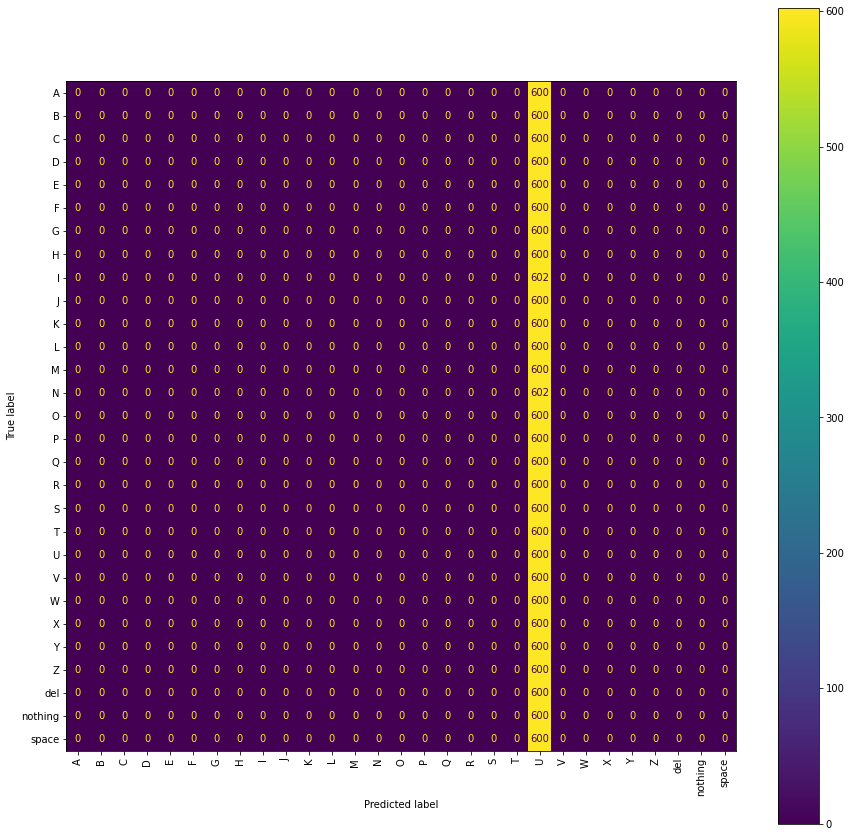

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_2l = Sequential()

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Flatten())
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Dense(128, activation='relu'))

model_5_2l.add(Dense(num_classes, activation='softmax'))

model_5_2l.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 57, 57, 32)        6176      
                                                                 
 activation_13 (Activation)  (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 32)        65568     
                                                                 
 activation_14 (Activation)  (None, 21, 21, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 78s 81ms/step - loss: 3.3759 - accuracy: 0.0164 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 77s 81ms/step - loss: 3.3777 - accuracy: 0.0292 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 77s 80ms/step - loss: 3.3700 - accuracy: 0.0226 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 77s 81ms/step - loss: 3.3700 - accuracy: 0.0266 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 77s 81ms/step - loss: 3.3703 - accuracy: 0.0221 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 76s 80ms/step - loss: 3.3698 - accuracy: 0.0208 - val_loss: 3.3673 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 77s 81ms/step - loss: 3.3703 - accuracy: 0.0178 - val_loss: 3.3673 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.375896  0.016400  3.367424      0.034475
1  3.377662  0.029189  3.367364      0.034475
2  3.370034  0.022622  3.367324      0.034475
3  3.369986  0.026595  3.367329      0.034475
4  3.370297  0.022064  3.367325      0.034475
5  3.369775  0.020800  3.367331      0.034475
6  3.370270  0.017845  3.367332      0.034475
7  3.369762  0.014496  3.367316      0.034475
8  3.369888  0.028713  3.367309      0.034475
9  3.369794  0.019503  3.367308      0.034590

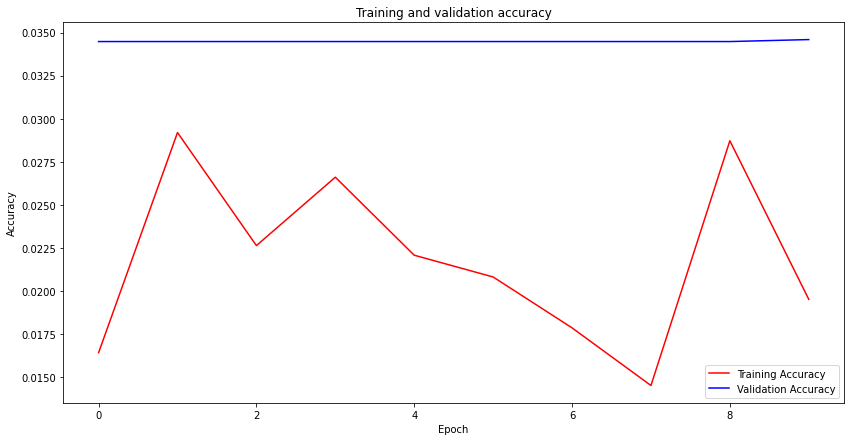

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_2l.history.history['accuracy']
val_acc= model_5_2l.history.history['val_accuracy']
loss= model_5_2l.history.history['loss']
val_loss= model_5_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

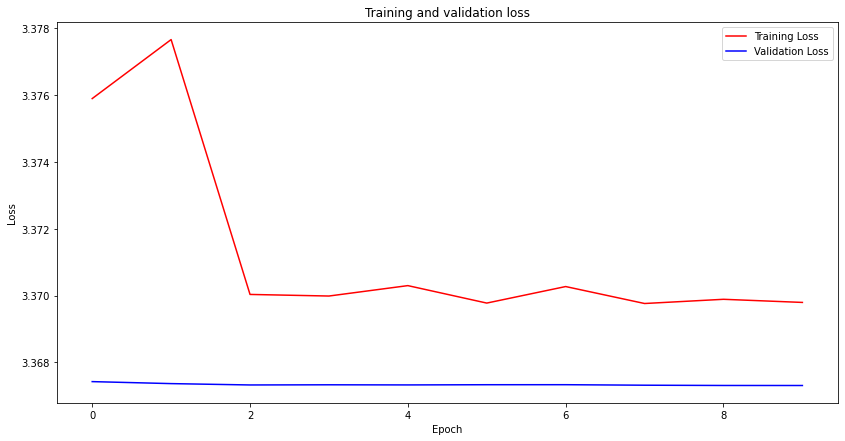

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 71ms/step - loss: 3.3673 - accuracy: 0.0346
loss : 3.367312431335449 acc : 0.034589748829603195


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 70ms/step
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.03      1.00      0.07       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

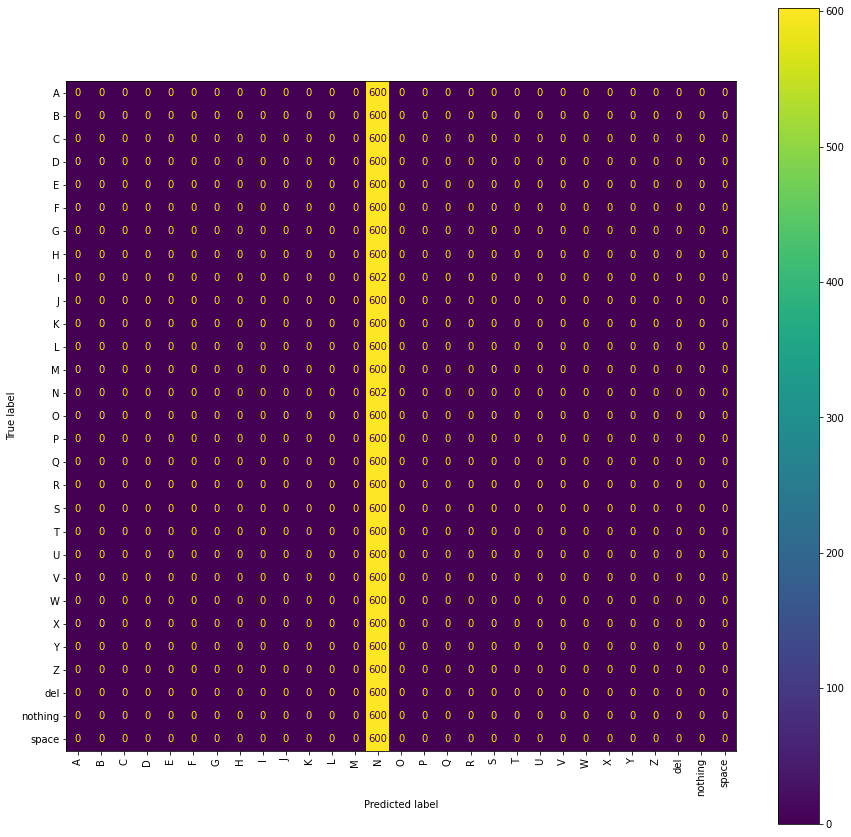

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')